ground truch colorfulness:  tensor(0.0125)
ground truch std:  tensor(77.2346) tensor(40.8312)
Loaded checkpoint from epoch 15
prediction colorfulness:  tensor(0.0131)
prediction std:  tensor(0.0079) tensor(0.0070)
Loaded checkpoint_improv from epoch 20
prediction colorfulness:  tensor(0.0131)
prediction std:  tensor(0.0018) tensor(0.0018)


/anaconda3/lib/python3.6/site-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 1 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


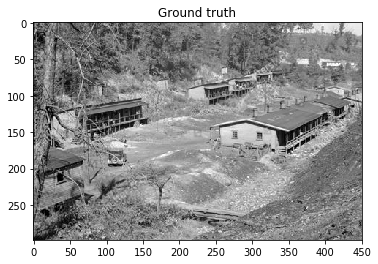

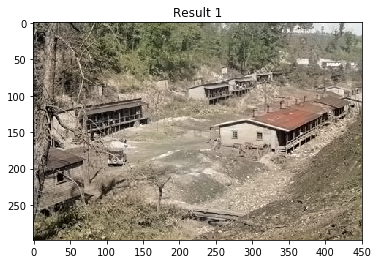

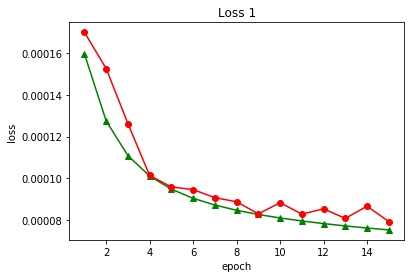

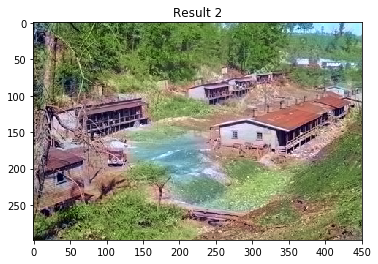

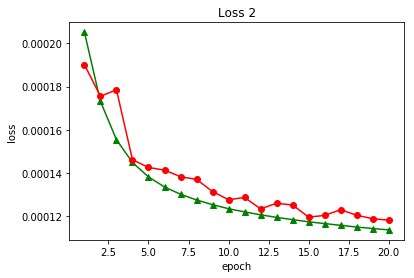

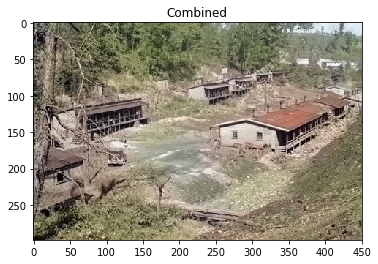

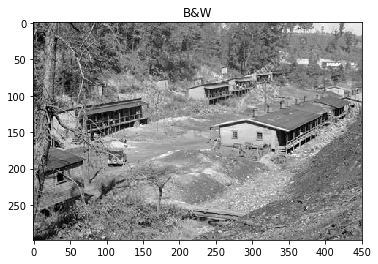

In [20]:
import os
import cv2
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2lab, lab2rgb
from model import Net 

save_imgs = False
test_img_name = 'test13.jpg'
checkpoint_name = 'checkpoint15.pth.tar'
checkpoint_improv_name = 'checkpoint20_improv.pth.tar'
weight = 0.2

def predict_colors(model, l):
    """
    Predict colors with the given model and the L layer.
    """
    with torch.no_grad():
        inputs = l.unsqueeze(0)
        color_preds, label_preds = model(inputs)
        # calculate colorfulness of the prediction
        print("prediction colorfulness: ", color_preds.pow(2).sum().sqrt().div(color_preds.pow(2).sum().add(l.pow(2).sum()).sqrt()))
        print("prediction std: ", 0.0001/color_preds[0,:,:,0].std(), 0.0001/color_preds[0,:,:,1].std())
        color_preds = color_preds * 255 - 128
        colors = color_preds
        l_orig = torch.from_numpy(rgb2lab(transforms.ToTensor()(img).permute(1, 2, 0)))[:, :, 0:1].float()
        color_preds = F.interpolate(color_preds.permute(0, 3, 1, 2), size=(l_orig.size(0), l_orig.size(1)), mode='nearest')
        color_preds = color_preds.permute(0, 2, 3, 1)  
        colorization_lab = torch.cat((l_orig, color_preds[0]), -1)
        colorization_rgb = lab2rgb(colorization_lab.double())
        return colors, colorization_rgb

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

img = Image.open(test_img_name)
plt.figure(0)
plt.title('Ground truth')
plt.imshow(img)
test_img = transform_test(img)
    
# rgb -> lab
lab = torch.from_numpy(rgb2lab(test_img.permute(1, 2, 0))).float()
l = lab[:, :, 0:1]
# normalize a&b to [0, 1]
ab = (lab[:, :, 1:] + 128) / 255
# calculate colorfulness of the ground truth
print("ground truch colorfulness: ", ab.pow(2).sum().sqrt().div(ab.pow(2).sum().add(l.pow(2).sum()).sqrt()))
print("ground truch std: ", 0.0001/ab[:,:,0].std(), 0.0001/ab[:,:,1].std())

# load model
model = Net()
checkpoint = torch.load(checkpoint_name, map_location=lambda storage, loc: storage)
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']
start_epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['state_dict'])
print('Loaded checkpoint from epoch %d' % start_epoch)
model.eval()

# predict colors
colors, colorization_rgb = predict_colors(model, l)
plt.figure(1)
plt.title('Result 1')
plt.imshow(colorization_rgb)
if save_imgs:
    plt.imsave(os.path.splitext(test_img_name)[0] + '_1.jpg', colorization_rgb)

plt.figure(2)
plt.title('Loss 1')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1, len(train_losses) + 1), train_losses, 'g-^', range(1, len(val_losses) + 1), val_losses, 'r-o')

# load model improv
checkpoint_improv = torch.load(checkpoint_improv_name, map_location=lambda storage, loc: storage)
train_losses = checkpoint_improv['train_losses']
val_losses = checkpoint_improv['val_losses']
start_epoch = checkpoint_improv['epoch']
model.load_state_dict(checkpoint_improv['state_dict'])
print('Loaded checkpoint_improv from epoch %d' % start_epoch)
model.eval()

# predict colors
colors_improv, colorization_rgb = predict_colors(model, l)
plt.figure(3)
plt.title('Result 2')
plt.imshow(colorization_rgb)
if save_imgs:
    plt.imsave(os.path.splitext(test_img_name)[0] + '_2.jpg', colorization_rgb)

plt.figure(4)
plt.title('Loss 2')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1, len(train_losses) + 1), train_losses, 'g-^', range(1, len(val_losses) + 1), val_losses, 'r-o')

with torch.no_grad():
    color_preds = (1 - weight) * colors + weight * colors_improv
    l_orig = torch.from_numpy(rgb2lab(transforms.ToTensor()(img).permute(1, 2, 0)))[:, :, 0:1].float()
    color_preds = F.interpolate(color_preds.permute(0, 3, 1, 2), size=(l_orig.size(0), l_orig.size(1)), mode='nearest')
    color_preds = color_preds.permute(0, 2, 3, 1)  
    colorization_lab = torch.cat((l_orig, color_preds[0]), -1)
    colorization_rgb = lab2rgb(colorization_lab.double())
    
plt.figure(5)
plt.title('Combined')
plt.imshow(colorization_rgb)
if save_imgs:
    plt.imsave(os.path.splitext(test_img_name)[0] + '_3.jpg', colorization_rgb)
    
with torch.no_grad():
    color_preds = 0 * colors
    l_orig = torch.from_numpy(rgb2lab(transforms.ToTensor()(img).permute(1, 2, 0)))[:, :, 0:1].float()
    color_preds = F.interpolate(color_preds.permute(0, 3, 1, 2), size=(l_orig.size(0), l_orig.size(1)), mode='nearest')
    color_preds = color_preds.permute(0, 2, 3, 1)  
    colorization_lab = torch.cat((l_orig, color_preds[0]), -1)
    colorization_rgb = lab2rgb(colorization_lab.double())
    
plt.figure(6)
plt.title('B&W')
plt.imshow(colorization_rgb)
if save_imgs:
    plt.imsave(os.path.splitext(test_img_name)[0] + '_0.jpg', colorization_rgb)   
    